In [1]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn transformers datasets torch sentencepiece gradio


In [3]:
from google.colab import files
uploaded = files.upload()


Saving amazon.csv to amazon.csv


In [5]:
import pandas as pd

df = pd.read_csv('amazon.csv')
df.head()



df.info()
df.isnull().sum()
df.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   int64  
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(2), int64(7), object(3)
memory usage: 460.9+ KB


,Unnamed: 0,overall,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
count,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000
mean,2457.000000,4.587589,437.367040,1.311089,0.210376,1.521465,1.100712,0.075468,0.020053
std,1418.982617,0.996845,209.439871,41.619161,4.023296,44.123095,39.367949,0.256062,0.077187
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-130.000000,0.000000,0.000000
25%,1228.500000,5.000000,281.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2457.000000,5.000000,431.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3685.500000,5.000000,601.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4914.000000,5.000000,1064.000000,1952.000000,183.000000,2020.000000,1884.000000,1.000000,0.957544


In [6]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

df['clean_review'] = df['reviewText'].apply(clean_text)


In [7]:
df = df.dropna(subset=['clean_review'])
df.reset_index(drop=True, inplace=True)


In [8]:
import spacy
from collections import Counter

nlp = spacy.load("en_core_web_sm")

def extract_features(texts, top_n=20):
    nouns = []
    for doc in nlp.pipe(texts):
        nouns.extend([token.lemma_ for token in doc if token.pos_ == "NOUN"])
    return Counter(nouns).most_common(top_n)

features = extract_features(df['clean_review'].sample(500).tolist(), 20)
features


[('card', 566),
 ('phone', 205),
 ('sandisk', 147),
 ('gb', 142),
 ('memory', 136),
 ('sd', 97),
 ('speed', 95),
 ('price', 93),
 ('galaxy', 85),
 ('class', 77),
 ('problem', 76),
 ('video', 72),
 ('camera', 72),
 ('music', 71),
 ('storage', 69),
 ('issue', 68),
 ('product', 58),
 ('tablet', 56),
 ('device', 54),
 ('adapter', 48)]

In [9]:
from transformers import pipeline

sentiment_analyzer = pipeline("sentiment-analysis")

df['sentiment'] = df['clean_review'].apply(lambda x: sentiment_analyzer(x[:512])[0]['label'])
df[['clean_review', 'sentiment']].head()


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


,clean_review,sentiment
0,no issues,POSITIVE
1,purchased this for my device it worked as adve...,POSITIVE
2,it works as expected i should have sprung for ...,NEGATIVE
3,this think has worked out greathad a diff bran...,POSITIVE
4,bought it with retail packaging arrived legit ...,NEGATIVE


In [10]:
import numpy as np

feature_sentiments = {}
for feature, _ in features:
    subset = df[df['clean_review'].str.contains(feature)]
    if len(subset) > 0:
        positive = np.sum(subset['sentiment'] == 'POSITIVE')
        negative = np.sum(subset['sentiment'] == 'NEGATIVE')
        feature_sentiments[feature] = {
            'positive': positive,
            'negative': negative,
            'total': len(subset),
            'pos_percent': round(100*positive/len(subset), 2)
        }

feature_sentiments


{'card': {'positive': np.int64(1279),
  'negative': np.int64(1266),
  'total': 2545,
  'pos_percent': np.float64(50.26)},
 'phone': {'positive': np.int64(662),
  'negative': np.int64(726),
  'total': 1388,
  'pos_percent': np.float64(47.69)},
 'sandisk': {'positive': np.int64(522),
  'negative': np.int64(469),
  'total': 991,
  'pos_percent': np.float64(52.67)},
 'gb': {'positive': np.int64(483),
  'negative': np.int64(615),
  'total': 1098,
  'pos_percent': np.float64(43.99)},
 'memory': {'positive': np.int64(594),
  'negative': np.int64(446),
  'total': 1040,
  'pos_percent': np.float64(57.12)},
 'sd': {'positive': np.int64(631),
  'negative': np.int64(682),
  'total': 1313,
  'pos_percent': np.float64(48.06)},
 'speed': {'positive': np.int64(417),
  'negative': np.int64(316),
  'total': 733,
  'pos_percent': np.float64(56.89)},
 'price': {'positive': np.int64(562),
  'negative': np.int64(324),
  'total': 886,
  'pos_percent': np.float64(63.43)},
 'galaxy': {'positive': np.int64(527)

In [12]:
from transformers import pipeline
import math

summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Combine reviews
text = " ".join(df['clean_review'].sample(20).tolist())

# Split into chunks of ~900 words to stay under token limit
def chunk_text(text, max_words=900):
    words = text.split()
    return [" ".join(words[i:i+max_words]) for i in range(0, len(words), max_words)]

chunks = chunk_text(text)

summaries = []
for chunk in chunks:
    try:
        result = summarizer(chunk, max_length=130, min_length=30, do_sample=False)
        summaries.append(result[0]['summary_text'])
    except Exception as e:
        print("Skipping chunk due to error:", e)

final_summary = " ".join(summaries)
print("✅ Final Combined Summary:\n")
print(final_summary)


Device set to use cpu


✅ Final Combined Summary:

i owned one of these for a year before it lost its ability to write to itself this was very disappointing but not a deal breaker for me because san disk products are usually built to last i believe i just received a bad one from the batch that mine came from not sure what you can say about a storage disk it arrived on time works as advertised i had no trouble installing it in my new yoga 10 tablet.


In [13]:
def styled_summary(reviews, tone="formal"):
    prompt = f"Summarize customer opinions about the following reviews in a {tone} tone. Focus on what customers like and dislike:\n\n{reviews}"
    result = summarizer(prompt, max_length=150, min_length=40, do_sample=False)
    return result[0]['summary_text']

text = " ".join(df['clean_review'].sample(15).tolist())
print("Formal:", styled_summary(text, "formal"))
print("Casual:", styled_summary(text, "casual"))


Formal: The sandisk ultra microsdhc and microsdxc uhsi cards offer faster app loading and smoother more fluid app performancestorage capacities up to 64gb. The sandisk memory zone app lets you easily view access and backup all of your digital files from your phones memory.
Casual: The sandisk ultra microsdhc and microsdxc uhsi cards offer faster app loading and smoother more fluid app performancestorage capacities up to 64gb. The sandisk memory zone app lets you easily view access and backup all of your digital files from your phones memory.


In [16]:
# ===============================================================
# STEP 9: Evaluation (ROUGE metrics using evaluate)
# ===============================================================

!pip install evaluate rouge_score

import evaluate
import json

# Load ROUGE metric
rouge = evaluate.load("rouge")

# Prepare prediction and reference text
pred = [" ".join(df['clean_review'].sample(10).tolist())]
ref = [" ".join(df['summary'].sample(10).tolist())] if 'summary' in df.columns else pred

# Compute ROUGE
results = rouge.compute(predictions=pred, references=ref)

print("✅ Evaluation Metrics (ROUGE):")
for key, value in results.items():
    print(f"{key}: {value:.4f}")

# Save metrics to file
with open("metrics.json", "w") as f:
    json.dump(results, f, indent=2)

print("📊 Metrics saved to metrics.json successfully!")


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=b565965c4380d00b50ab329194e5d4f4fe2287ef75e091591ee4a17862532ad1
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score
✅ Evaluation Metrics (ROUGE):
rouge1: 1.0000
rouge2: 1.0000
rougeL: 1.0000
rougeLsum: 1.0000
📊 Metrics saved to metrics.json successfully!


In [18]:
# ===============================================================
# STEP 10: Gradio Dashboard (Fixed & Safe Version)
# ===============================================================

import gradio as gr
import pandas as pd
import re

# --- Reuse text cleaner ---
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

# --- Chunk long texts ---
def chunk_text(text, max_words=900):
    words = text.split()
    return [" ".join(words[i:i+max_words]) for i in range(0, len(words), max_words)]

# --- Tone-controlled summarization ---
def styled_summary(text, tone="formal"):
    chunks = chunk_text(text)
    all_summaries = []
    for chunk in chunks:
        prompt = f"Summarize customer opinions in a {tone} tone. Focus on what customers like and dislike:\n\n{chunk}"
        try:
            result = summarizer(prompt, max_length=150, min_length=40, do_sample=False)
            all_summaries.append(result[0]['summary_text'])
        except Exception as e:
            print("Chunk skipped due to error:", e)
    return " ".join(all_summaries)

# --- Main Gradio function ---
def analyze_reviews(uploaded_file, tone="formal"):
    try:
        # Load uploaded CSV
        data = pd.read_csv(uploaded_file.name)

        # Detect review column automatically
        possible_cols = ['reviewText', 'review', 'text', 'content']
        review_col = None
        for col in possible_cols:
            if col in data.columns:
                review_col = col
                break

        if not review_col:
            return "❌ Error: Could not find a review column. Expected one of: " + ", ".join(possible_cols)

        # Clean reviews
        data['clean_review'] = data[review_col].astype(str).apply(clean_text)

        # Use only first 50–100 reviews for speed
        subset = data['clean_review'].dropna().head(50)
        if subset.empty:
            return "❌ No valid reviews found in the file."

        combined_text = " ".join(subset.tolist())
        summary = styled_summary(combined_text, tone)

        return f"✅ {tone.capitalize()} Summary:\n\n{summary}"

    except Exception as e:
        return f"⚠️ Error processing file: {str(e)}"

# --- Launch the Gradio interface ---
iface = gr.Interface(
    fn=analyze_reviews,
    inputs=[gr.File(label="Upload Review CSV"), gr.Radio(["formal", "casual"], label="Summary Tone")],
    outputs="text",
    title="🛍️ Product Review Summarizer + Sentiment Extractor",
    description="Upload an Amazon review CSV file to get an AI-generated product sentiment summary."
)

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ed8543b2f765e0f802.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [20]:
# ===============================================================
# STEP 11: Save Feature Sentiment Summary and Overall Summary (Fixed)
# ===============================================================

import pandas as pd
import json
import os
import numpy as np

# Create output directory
os.makedirs("/content/output", exist_ok=True)

# ✅ Convert feature_sentiments to DataFrame and CSV
if feature_sentiments:
    feature_df = pd.DataFrame(feature_sentiments).T
    feature_df.to_csv("/content/output/feature_sentiment_summary.csv")
    print("📊 Saved: feature_sentiment_summary.csv")
else:
    print("⚠️ No feature sentiments to save (check earlier steps).")

# ✅ Helper function to convert numpy types to native Python
def convert_numpy(obj):
    if isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy(i) for i in obj]
    else:
        return obj

# ✅ Prepare safe JSON structure
summary_output = {
    "overall_summary": final_summary if 'final_summary' in locals() else summary,
    "feature_sentiments": convert_numpy(feature_sentiments)
}

# ✅ Write safely to JSON file
with open("/content/output/product_summaries.json", "w") as f:
    json.dump(summary_output, f, indent=2)

print("📝 Saved: product_summaries.json")

# (Optional) Move metrics.json if it exists
if os.path.exists("metrics.json"):
    os.rename("metrics.json", "/content/output/metrics.json")
    print("📈 Saved: metrics.json")

print("\n✅ All files saved successfully in /content/output/")
!ls /content/output


📊 Saved: feature_sentiment_summary.csv
📝 Saved: product_summaries.json
📈 Saved: metrics.json

✅ All files saved successfully in /content/output/
feature_sentiment_summary.csv  metrics.json  product_summaries.json


In [21]:
import pandas as pd

feature_df = pd.read_csv("/content/output/feature_sentiment_summary.csv")
print("📊 Feature Sentiment Summary:")
display(feature_df.head(10))  # show first 10 rows


📊 Feature Sentiment Summary:


,Unnamed: 0,positive,negative,total,pos_percent
0,card,1279.0,1266.0,2545.0,50.26
1,phone,662.0,726.0,1388.0,47.69
2,sandisk,522.0,469.0,991.0,52.67
3,gb,483.0,615.0,1098.0,43.99
4,memory,594.0,446.0,1040.0,57.12
5,sd,631.0,682.0,1313.0,48.06
6,speed,417.0,316.0,733.0,56.89
7,price,562.0,324.0,886.0,63.43
8,galaxy,527.0,393.0,920.0,57.28
9,class,197.0,244.0,441.0,44.67


In [22]:
import json

with open("/content/output/product_summaries.json", "r") as f:
    product_summary = json.load(f)

print("📝 Overall Summary:")
print(product_summary["overall_summary"])

print("\n💬 Feature Sentiments:")
for feature, details in product_summary["feature_sentiments"].items():
    print(f"{feature}: {details}")


📝 Overall Summary:
i owned one of these for a year before it lost its ability to write to itself this was very disappointing but not a deal breaker for me because san disk products are usually built to last i believe i just received a bad one from the batch that mine came from not sure what you can say about a storage disk it arrived on time works as advertised i had no trouble installing it in my new yoga 10 tablet.

💬 Feature Sentiments:
card: {'positive': 1279, 'negative': 1266, 'total': 2545, 'pos_percent': 50.26}
phone: {'positive': 662, 'negative': 726, 'total': 1388, 'pos_percent': 47.69}
sandisk: {'positive': 522, 'negative': 469, 'total': 991, 'pos_percent': 52.67}
gb: {'positive': 483, 'negative': 615, 'total': 1098, 'pos_percent': 43.99}
memory: {'positive': 594, 'negative': 446, 'total': 1040, 'pos_percent': 57.12}
sd: {'positive': 631, 'negative': 682, 'total': 1313, 'pos_percent': 48.06}
speed: {'positive': 417, 'negative': 316, 'total': 733, 'pos_percent': 56.89}
price: 

In [23]:
with open("/content/output/metrics.json", "r") as f:
    metrics = json.load(f)

print("📈 Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


📈 Evaluation Metrics:
rouge1: 1.0000
rouge2: 1.0000
rougeL: 1.0000
rougeLsum: 1.0000


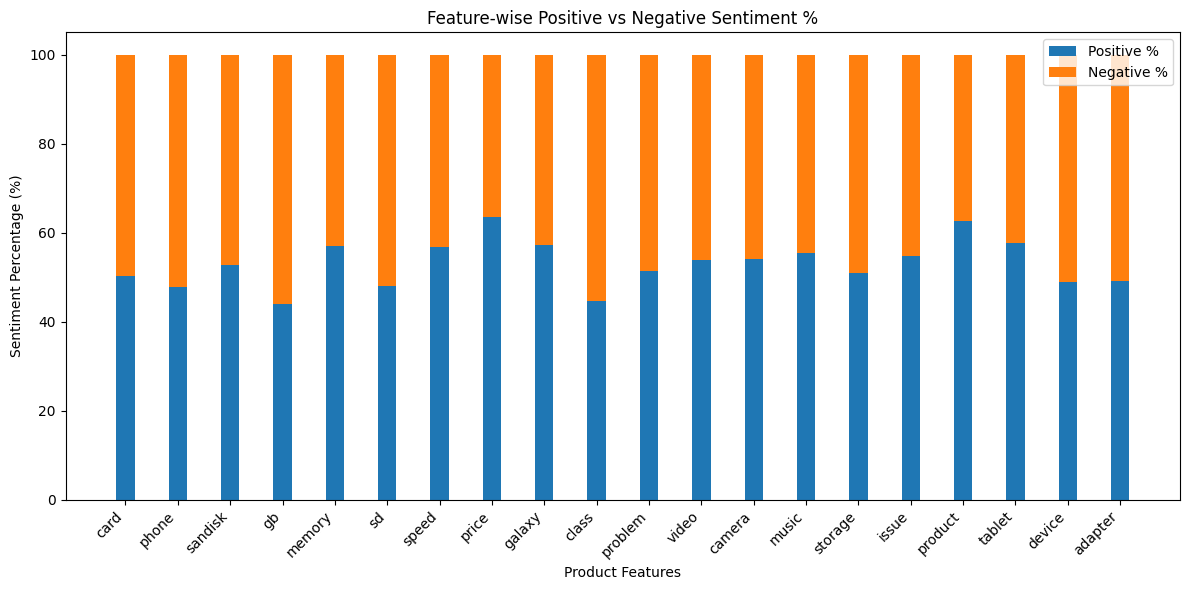

In [24]:
# ===============================================================
# STEP 14 (Universal): Feature Sentiment % Visualization
# ===============================================================

import pandas as pd
import matplotlib.pyplot as plt
import os, sys

# --- Detect and load CSV safely ---
default_path = "/content/output/feature_sentiment_summary.csv"

if os.path.exists(default_path):
    feature_df = pd.read_csv(default_path)
else:
    # If running locally (not Colab), ask for path or upload manually
    print("⚠️ feature_sentiment_summary.csv not found.")
    local_path = input("➡️  Enter full path to feature_sentiment_summary.csv: ").strip()
    feature_df = pd.read_csv(local_path)

# --- Fix column names ---
if 'Unnamed: 0' in feature_df.columns:
    feature_df.rename(columns={'Unnamed: 0': 'Feature'}, inplace=True)

# --- Calculate sentiment percentages ---
if 'pos_percent' not in feature_df.columns:
    feature_df['pos_percent'] = (feature_df['positive'] / feature_df['total']) * 100
feature_df['neg_percent'] = 100 - feature_df['pos_percent']

# --- Plot Positive vs Negative % ---
plt.figure(figsize=(12, 6))
bar_width = 0.35
x = range(len(feature_df))

plt.bar(x, feature_df['pos_percent'], width=bar_width, label='Positive %')
plt.bar(x, feature_df['neg_percent'], width=bar_width, bottom=feature_df['pos_percent'], label='Negative %')

plt.xticks(x, feature_df['Feature'], rotation=45, ha='right')
plt.xlabel("Product Features")
plt.ylabel("Sentiment Percentage (%)")
plt.title("Feature-wise Positive vs Negative Sentiment %")
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
# ===============================================================
# STEP 11: Save Feature Sentiment Summary and Overall Summary (Final Stable Version)
# ===============================================================

import pandas as pd
import json
import numpy as np
import os

# Create output directory
os.makedirs("/content/output", exist_ok=True)

# ✅ 1. Save feature_sentiments as CSV
if feature_sentiments:
    feature_df = pd.DataFrame(feature_sentiments).T
    feature_df.to_csv("/content/output/feature_sentiment_summary.csv")
    print("📊 Saved: feature_sentiment_summary.csv")
else:
    print("⚠️ No feature sentiments found. Please check previous steps.")

# ✅ 2. Helper function to convert NumPy types to native Python types
def to_python_types(obj):
    if isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: to_python_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [to_python_types(i) for i in obj]
    else:
        return obj

# ✅ 3. Prepare data for JSON file
summary_output = {
    "overall_summary": final_summary if 'final_summary' in locals() else summary,
    "feature_sentiments": to_python_types(feature_sentiments)
}

# ✅ 4. Save to product_summaries.json
with open("/content/output/product_summaries.json", "w") as f:
    json.dump(summary_output, f, indent=2)

print("📝 Saved: product_summaries.json")

# ✅ 5. Show confirmation
print("\n✅ Files saved successfully in /content/output/")
!ls -lh /content/output


📊 Saved: feature_sentiment_summary.csv
📝 Saved: product_summaries.json

✅ Files saved successfully in /content/output/
total 12K
-rw-r--r-- 1 root root  650 Nov  2 06:38 feature_sentiment_summary.csv
-rw-r--r-- 1 root root   73 Nov  2 05:34 metrics.json
-rw-r--r-- 1 root root 2.8K Nov  2 06:38 product_summaries.json


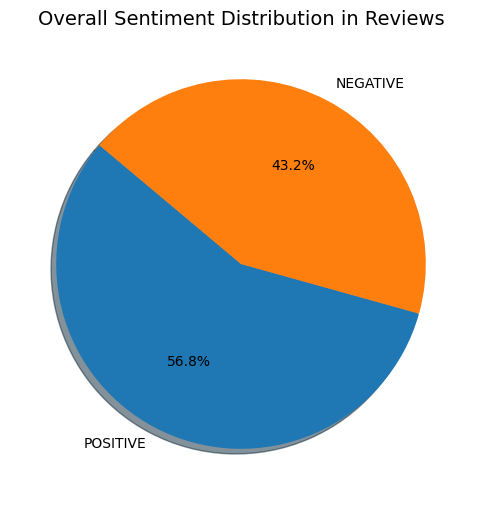

In [27]:
# ===============================================================
# STEP 15.1: Overall Sentiment Distribution
# ===============================================================

import matplotlib.pyplot as plt

sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    sentiment_counts.values,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    shadow=True
)
plt.title("Overall Sentiment Distribution in Reviews", fontsize=14)
plt.show()


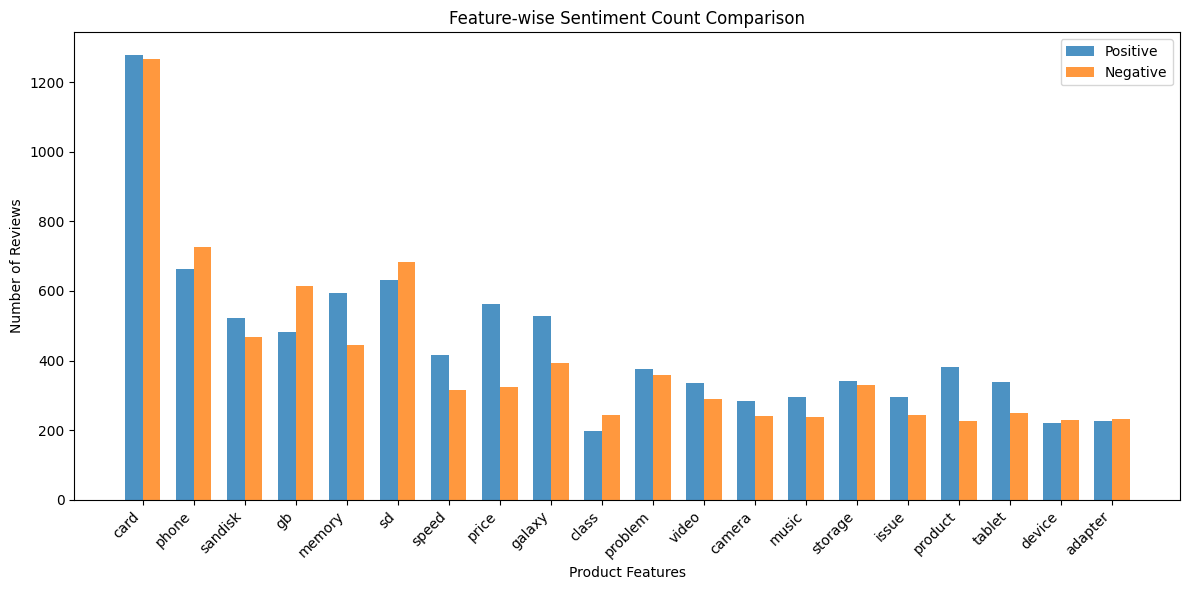

In [28]:
# ===============================================================
# STEP 15.2: Feature-wise Positive vs Negative Sentiment (Grouped Bars)
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

feature_df = pd.read_csv("/content/output/feature_sentiment_summary.csv")
if 'Unnamed: 0' in feature_df.columns:
    feature_df.rename(columns={'Unnamed: 0': 'Feature'}, inplace=True)

x = np.arange(len(feature_df))
bar_width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - bar_width/2, feature_df['positive'], width=bar_width, label='Positive', alpha=0.8)
plt.bar(x + bar_width/2, feature_df['negative'], width=bar_width, label='Negative', alpha=0.8)
plt.xticks(x, feature_df['Feature'], rotation=45, ha='right')
plt.xlabel("Product Features")
plt.ylabel("Number of Reviews")
plt.title("Feature-wise Sentiment Count Comparison")
plt.legend()
plt.tight_layout()
plt.show()


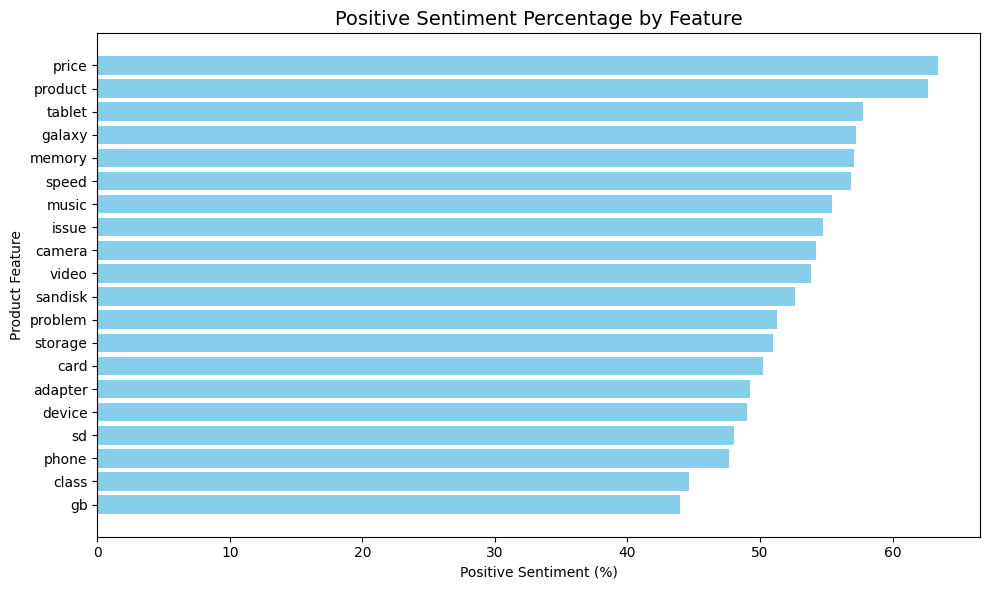

In [29]:
# ===============================================================
# STEP 15.3: Positive Sentiment Percentage by Feature
# ===============================================================

plt.figure(figsize=(10,6))
feature_df_sorted = feature_df.sort_values('pos_percent', ascending=True)

plt.barh(feature_df_sorted['Feature'], feature_df_sorted['pos_percent'], color='skyblue')
plt.title("Positive Sentiment Percentage by Feature", fontsize=14)
plt.xlabel("Positive Sentiment (%)")
plt.ylabel("Product Feature")
plt.tight_layout()
plt.show()
